In [233]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import time 

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn import preprocessing

from sklearn.model_selection import train_test_split, KFold,cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.metrics import f1_score,confusion_matrix
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier


from skfeature.function.similarity_based import fisher_score
from skfeature.utility import construct_W
from skfeature.function.similarity_based import lap_score



DATA_PATH = './data/data.csv'

## Reference
- skfeature : http://featureselection.asu.edu/tutorial.php

### Data 전처리

In [234]:
data = pd.read_csv(DATA_PATH)
y = data.diagnosis
temp_list = ['Unnamed: 32', 'id', 'diagnosis']
x = data.drop(temp_list, axis =1)

In [235]:
data_label = y
data = x
data_normalize = (data- data.mean()) / (data.std())

col_name_list = data_normalize.columns
print(col_name_list)
data_normalize.head()


Index(['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean',
       'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')


,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1.096100,-2.071512,1.268817,0.983510,1.567087,3.280628,2.650542,2.530249,2.215566,2.253764,...,1.885031,-1.358098,2.301575,1.999478,1.306537,2.614365,2.107672,2.294058,2.748204,1.935312
1,1.828212,-0.353322,1.684473,1.907030,-0.826235,-0.486643,-0.023825,0.547662,0.001391,-0.867889,...,1.804340,-0.368879,1.533776,1.888827,-0.375282,-0.430066,-0.146620,1.086129,-0.243675,0.280943
2,1.578499,0.455786,1.565126,1.557513,0.941382,1.052000,1.362280,2.035440,0.938859,-0.397658,...,1.510541,-0.023953,1.346291,1.455004,0.526944,1.081980,0.854222,1.953282,1.151242,0.201214
3,-0.768233,0.253509,-0.592166,-0.763792,3.280667,3.399917,1.914213,1.450431,2.864862,4.906602,...,-0.281217,0.133866,-0.249720,-0.549538,3.391291,3.889975,1.987839,2.173873,6.040726,4.930672
4,1.748758,-1.150804,1.775011,1.824624,0.280125,0.538866,1.369806,1.427237,-0.009552,-0.561956,...,1.297434,-1.465481,1.337363,1.219651,0.220362,-0.313119,0.612640,0.728618,-0.867590,-0.396751


In [236]:
min_max_scaler = preprocessing.MinMaxScaler()
min_max_data = min_max_scaler.fit_transform(data_normalize)
data_normal_scale = pd.DataFrame(min_max_data)

data_normal_scale.columns = col_name_list
data_normal_scale.head()

temp_data_scale = min_max_scaler.fit_transform(data)
temp_data_scale = pd.DataFrame(min_max_data)
temp_data_scale.columns = col_name_list
temp_data_scale.head()


,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,0.521037,0.022658,0.545989,0.363733,0.593753,0.792037,0.703140,0.731113,0.686364,0.605518,...,0.620776,0.141525,0.668310,0.450698,0.601136,0.619292,0.568610,0.912027,0.598462,0.418864
1,0.643144,0.272574,0.615783,0.501591,0.289880,0.181768,0.203608,0.348757,0.379798,0.141323,...,0.606901,0.303571,0.539818,0.435214,0.347553,0.154563,0.192971,0.639175,0.233590,0.222878
2,0.601496,0.390260,0.595743,0.449417,0.514309,0.431017,0.462512,0.635686,0.509596,0.211247,...,0.556386,0.360075,0.508442,0.374508,0.483590,0.385375,0.359744,0.835052,0.403706,0.213433
3,0.210090,0.360839,0.233501,0.102906,0.811321,0.811361,0.565604,0.522863,0.776263,1.000000,...,0.248310,0.385928,0.241347,0.094008,0.915472,0.814012,0.548642,0.884880,1.000000,0.773711
4,0.629893,0.156578,0.630986,0.489290,0.430351,0.347893,0.463918,0.518390,0.378283,0.186816,...,0.519744,0.123934,0.506948,0.341575,0.437364,0.172415,0.319489,0.558419,0.157500,0.142595


## Get Score steps  
- 카이제곱 스코어  
- Fisher 스코어  
- Laplacian 스코어  
- Ranking system




In [237]:
temp = np.zeros(29)
print(len(temp))

29


In [277]:
def get_fisher_score(data,label,k = 30):
    score = fisher_score.fisher_score(data_normal_scale, y)
    #print(score)
    ranking = fisher_score.feature_ranking(score)
    #print(idx)
    
    
    dfscores = pd.DataFrame(score)
    dfcolumns = pd.DataFrame(data.columns)
    #df_rank =pd.DataFrame(idx)
    
    featureScores = pd.concat([dfcolumns,dfscores],axis=1)
    featureScores.columns = ['Feature','Score']  #naming the dataframe columns
    #print(featureScores.nlargest(k,'Score'))  #print 20 best features
    result = featureScores.nlargest(k,'Score')
    
    return result, ranking
    
    
def get_lap_score(data,label, k=5, t=1,top_feature = 30):
    kwargs_W = {"metric":"euclidean","neighbor_mode":"knn","weight_mode":"heat_kernel","k":k,'t':t}
    W = construct_W.construct_W(data_normal_scale, **kwargs_W)
    score = lap_score.lap_score(data_normal_scale, W=W)
    #print(score)
    ranking = lap_score.feature_ranking(score)
    #print(idx)
    
    dfscores = pd.DataFrame(score)
    dfcolumns = pd.DataFrame(data.columns)
    #df_rank = pd.DataFrame(idx)
    
    featureScores = pd.concat([dfcolumns,dfscores],axis=1)
    featureScores.columns = ['Feature','Score']  #naming the dataframe columns
    #print(featureScores.nlargest(k,'Score'))  #print 20 best features
    result = featureScores.nlargest(top_feature,'Score')
    
    return result, ranking
    
    
def get_chi_score(data,label, k =30):
    '''
    Input
        data : pandas dataframe 
        label : binary class label
        k : number of features
        
    Output : sorted kai-score list
    
    '''
    ranking_list = []
    x = data
    y = label 
    
    
    #target column i.e price range
    #apply SelectKBest class to extract top 20 best features
    bestfeatures = SelectKBest(score_func=chi2, k=k)
    fit = bestfeatures.fit(data,label)
    dfscores = pd.DataFrame(fit.scores_)
    dfcolumns = pd.DataFrame(data.columns)
    
    #concat two dataframes for better visualization 
    featureScores = pd.concat([dfcolumns,dfscores],axis=1)
    featureScores.columns = ['Feature','Score']  #naming the dataframe columns
    #print(featureScores.nlargest(k,'Score'))  #print 20 best features
    result = featureScores.nlargest(k,'Score')
    #print(temp)
    #print(temp.iloc[0])
    ranking_list = list(result['Feature'].index)   
    
    return result,ranking_list


def get_feature_ranking(raw_data,chi_rank, fisher_rank,lap_rank):
    '''
    Input
        chi_rank : chi_squared ranking 
        fisher_rank : fisher ranking
        lap_rank : laplacian ranking
    Output
        final_rank : final ranking, chi + fisher + lap, sorting result
        
    '''
    
    final_rank = np.zeros(30)
    
    col_name_list = raw_data.columns
    df_feature = pd.DataFrame(col_name_list)

    reverse_chi = np.flip(chi_rank,0)
    reverse_fisher = np.flip(fisher_rank,0)
    reverse_lap = np.flip(lap_rank,0)
    
    chi_rank_score_list = []
    fisher_rank_score_list = []
    lap_rank_score_list = []
    
    for idx in range(len(reverse_chi)):
        rank_score = (1/29) * idx 
        chi_rank_score_list.append((reverse_chi[idx],rank_score))
        fisher_rank_score_list.append((reverse_fisher[idx],rank_score))
        lap_rank_score_list.append((reverse_lap[idx],rank_score))
        
        final_rank[reverse_chi[idx]] = final_rank[reverse_chi[idx]] + rank_score
        final_rank[reverse_fisher[idx]] = final_rank[reverse_fisher[idx]] + rank_score
        final_rank[reverse_lap[idx]] = final_rank[reverse_lap[idx]] + rank_score

    #print(final_rank)
    #print(chi_rank_score_list)
    
    df_ranking = pd.DataFrame(final_rank)
    df_col = pd.DataFrame(col_name_list)
    featureScores = pd.concat([df_col,df_ranking],axis=1)
    featureScores.columns = ['Feature','ranking']  #naming the dataframe columns
    
    
    result = featureScores.nlargest(30,'ranking')
    print(result)
    
    return final_rank, result
    
#chi_score_list_normal_scale = get_chi_score(data_normal_scale,data_label)
chi_score_list_raw,chi_rank = get_chi_score(data,data_label)
#chi_score_list_scale = get_chi_score(temp_data_scale,data_label)
temp1,fisher_rank =get_fisher_score(data_normal_scale,y)
temp2,lap_rank=get_lap_score(data_normal_scale,y)

final_rank,final_result = get_feature_ranking(data_normal_scale, chi_rank,fisher_rank,lap_rank)
#print('chi rank : {} fisher rank : {} lap rank : {} '.format(chi_rank,fisher_rank,lap_rank) )
#print('[Reverse] chi rank : {} fisher rank : {} lap rank : {} '.format(np.flip(chi_rank,0),np.flip(fisher_rank,0),np.flip(lap_rank,0)) )

                    Feature   ranking
22          perimeter_worst  2.862069
23               area_worst  2.724138
20             radius_worst  2.689655
3                 area_mean  2.586207
2            perimeter_mean  2.551724
0               radius_mean  2.344828
7       concave points_mean  2.344828
27     concave points_worst  2.310345
6            concavity_mean  2.034483
13                  area_se  2.000000
26          concavity_worst  2.000000
25        compactness_worst  1.793103
5          compactness_mean  1.793103
21            texture_worst  1.793103
12             perimeter_se  1.620690
10                radius_se  1.482759
1              texture_mean  1.448276
24         smoothness_worst  1.275862
15           compactness_se  0.965517
28           symmetry_worst  0.931034
29  fractal_dimension_worst  0.896552
17        concave points_se  0.862069
4           smoothness_mean  0.827586
16             concavity_se  0.758621
8             symmetry_mean  0.689655
9    fractal

In [278]:
temp1,fisher_rank

(                    Feature     Score
 27     concave points_worst  1.700856
 22          perimeter_worst  1.583676
 7       concave points_mean  1.519711
 20             radius_worst  1.518134
 2            perimeter_mean  1.229692
 23               area_worst  1.166843
 0               radius_mean  1.141060
 3                 area_mean  1.010689
 6            concavity_mean  0.941434
 26          concavity_worst  0.770180
 5          compactness_mean  0.552439
 25        compactness_worst  0.536757
 10                radius_se  0.474145
 12             perimeter_se  0.447791
 13                  area_se  0.429721
 21            texture_worst  0.263839
 24         smoothness_worst  0.216002
 28           symmetry_worst  0.209630
 1              texture_mean  0.208282
 17        concave points_se  0.199758
 4           smoothness_mean  0.147533
 8             symmetry_mean  0.122623
 29  fractal_dimension_worst  0.117185
 15           compactness_se  0.093911
 16             concavity

In [279]:
temp2,lap_rank

(                    Feature     Score
 18              symmetry_se  0.389442
 14            smoothness_se  0.352192
 11               texture_se  0.294414
 28           symmetry_worst  0.280945
 19     fractal_dimension_se  0.275966
 8             symmetry_mean  0.261482
 16             concavity_se  0.230877
 17        concave points_se  0.227426
 10                radius_se  0.209268
 12             perimeter_se  0.204753
 4           smoothness_mean  0.200331
 1              texture_mean  0.200033
 15           compactness_se  0.198070
 29  fractal_dimension_worst  0.188476
 9    fractal_dimension_mean  0.183858
 24         smoothness_worst  0.181468
 13                  area_se  0.170987
 21            texture_worst  0.168997
 25        compactness_worst  0.111559
 26          concavity_worst  0.108950
 5          compactness_mean  0.093500
 6            concavity_mean  0.067730
 0               radius_mean  0.064922
 27     concave points_worst  0.063395
 2            perimeter_m

## Featrue Select Algorithm
- Sphere selectortop_feature

In [239]:
def sphere_selector(data, n, initial):
    '''
    Input
        data
        n
        initial
    
    '''
    #data = (data-data.mean())/data.std()
    data = data
    dissmat = pd.DataFrame(np.arccos(np.corrcoef(data.values.T)),index=data.columns,columns=data.columns)
    result = [initial]
    n-=1
    while(n!=0):
        n -= 1
        result += [dissmat[result].min(axis=1).idxmax()]
    return result

select_feature_list = sphere_selector(data_normal_scale,10,'area_worst')

print(select_feature_list)


['area_worst', 'fractal_dimension_mean', 'texture_se', 'symmetry_worst', 'concave points_se', 'texture_mean', 'smoothness_se', 'symmetry_se', 'smoothness_worst', 'concavity_worst']


## Learning Algorithm

In [351]:
def feature_sphere_test(data, label,dominant_features):
    '''
    Find optimized featrue
    Input
        data 
        label
    Output
        1. optimized feature number
        2. Optimized feature plot
    
    '''
    model_list,acc_list = init_model_list()
 

    for i in range(len(x.columns)):
        select_feature_list = sphere_selector(data,i+1,dominant_features)
        x_selected = x[select_feature_list]
        x_train, x_test, y_train, y_test = train_test_split(x_selected,label, test_size=0.2, random_state=42)
        
        idx = 0
        for name, model in model_list:
            model.fit(x_train, y_train)
            #kfold = KFold(n_splits=5, random_state=7)
            #accuracy_results =cross_val_score(model, x_train,y_train, cv=kfold, scoring='accuracy')
            #acc_list[idx].append(accuracy_results)
            model_acc = accuracy_score(y_test, model.predict(x_test))
            acc_list[idx].append(model_acc)
            
            #print(accuracyMessage) 
            idx = idx+1
            
    return model_list,acc_list
    

def feature_cluster_test(data, label):
    '''
    Find optimized featrue
    Input
        data 
        label
    Output
        1. optimized feature number
        2. Optimized feature plot
    
    '''
    model_list,acc_list = init_model_list()
    acc_list = np.zeros(len(model_list))

    x_selected = data
    x_train, x_test, y_train, y_test = train_test_split(x_selected,label, test_size=0.2, random_state=42)

    idx = 0
    for name, model in model_list:
        model.fit(x_train, y_train)
        #kfold = KFold(n_splits=5, random_state=7)
        #accuracy_results =cross_val_score(model, x_train,y_train, cv=kfold, scoring='accuracy')
        #acc_list[idx].append(accuracy_results)
        model_acc = accuracy_score(y_test, model.predict(x_test))
        #acc_list[idx].append(model_acc)
        acc_list[idx] = model_acc
        #print(accuracyMessage) 
        idx = idx+1
            
    return model_list,acc_list

def init_model_list():
    '''
    No Input
    
    Output : model list
    '''
    models = []
    
    models.append(('LR', LogisticRegression()))
    models.append(('RF', RandomForestClassifier()))
    models.append(('KNN', KNeighborsClassifier()))
    models.append(('SVM', SVC()))
    models.append(('LSVM', LinearSVC()))
    models.append(('GNB', GaussianNB()))
    models.append(('DTC', DecisionTreeClassifier()))
    models.append(('GBC', GradientBoostingClassifier()))
    models.append(('XG', XGBClassifier()))
    
    acc_lists = [[] for i in range(len(models))]
    
    return models,acc_lists

def learning_model_test(x_train,y_train,x_test,y_test):
    '''
    Input
        x_train
        y_train
        x_test
        y_test
    Output
        acc_result : each model acc value
    
    '''
 
    print('\nCompare Multiple Classifiers: \n')
    print('K-Fold Cross-Validation Accuracy: \n')
    names = []
    models = []
    resultsAccuracy = []
    models.append(('LR', LogisticRegression()))
    models.append(('RF', RandomForestClassifier()))
    models.append(('KNN', KNeighborsClassifier()))
    models.append(('SVM', SVC()))
    models.append(('LSVM', LinearSVC()))
    models.append(('GNB', GaussianNB()))
    models.append(('DTC', DecisionTreeClassifier()))
    models.append(('GBC', GradientBoostingClassifier()))
    models.append(('XG', XGBClassifier()))
    
    for name, model in models:
        model.fit(x_train, y_train)
        kfold = KFold(n_splits=10, random_state=7)
        accuracy_results =cross_val_score(model, x_train,y_train, cv=kfold, scoring='accuracy')
        resultsAccuracy.append(accuracy_results)
        names.append(name)
        accuracyMessage = "%s: %f (%f)" % (name, accuracy_results.mean(), accuracy_results.std())
        print(accuracyMessage) 
    # Boxplot
    fig = plt.figure()
    fig.suptitle('Algorithm Comparison: Accuracy')
    ax = fig.add_subplot(111)
    plt.boxplot(resultsAccuracy)
    ax.set_xticklabels(names)
    ax.set_ylabel('Cross-Validation: Accuracy Score')
    plt.show()
    
def plot_model_acc(model_list,model_acc_list,file_name,fig_size = (12,12)):
    plt.figure(figsize=fig_size)
    plt.xlabel('number of feature')
    plt.ylabel('acc')
    
    idx = 0
    for name,_ in model_list:
        plt.plot(range(len(model_acc_list[idx])), model_acc_list[idx], label=name)
        idx = idx+1
        
    plt.legend()
    plt.savefig(file_name+'.png')

    
    
    

In [247]:
final_result

,Feature,ranking
23,area_worst,2.689655
20,radius_worst,2.655172
3,area_mean,2.551724
2,perimeter_mean,2.517241
0,radius_mean,2.310345
7,concave points_mean,2.310345
6,concavity_mean,2.000000
13,area_se,1.965517
26,concavity_worst,1.965517
22,perimeter_worst,1.827586


In [266]:
target_feature = 'fractal_dimension_se'

model_list, acc_list = feature_sphere_test(data_normal_scale,y,target_feature)

/home/bono/.pyenv/versions/3.6.5/envs/math_camp/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bono/.pyenv/versions/3.6.5/envs/math_camp/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/bono/.pyenv/versions/3.6.5/envs/math_camp/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/bono/.pyenv/versions/3.6.5/envs/math_camp/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be chang

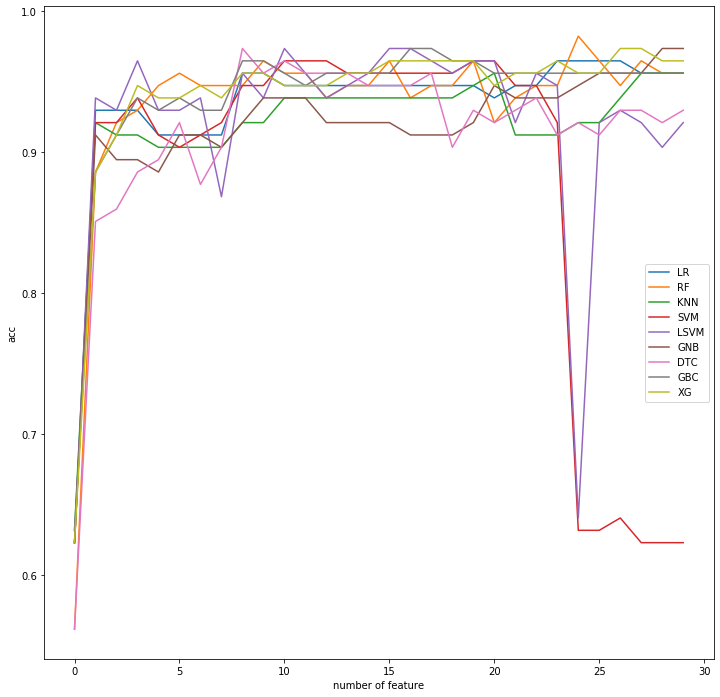

In [267]:
plot_model_acc(model_list,acc_list,target_feature)

In [ ]:
cluster_list= [['texture_worst'],
 ['texture_se'],
 ['perimeter_worst',
  'area_mean',
  'area_worst',
  'perimeter_mean',
  'radius_worst',
  'radius_mean'],
 ['concave points_se',
  'symmetry_se',
  'fractal_dimension_se',
  'compactness_se',
  'concavity_se'],
 ['texture_mean'],
 ['area_se', 'radius_se', 'perimeter_se'],
 ['smoothness_se'],
 ['fractal_dimension_mean'],
 ['concavity_mean',
  'concavity_worst',
  'compactness_mean',
  'concave points_mean',
  'compactness_worst',
  'concave points_worst'],
 ['smoothness_mean',
  'smoothness_worst',
  'symmetry_mean',
  'fractal_dimension_worst',
  'symmetry_worst']]

print(cluster_list)

In [ ]:
type(final_result['Feature'])

In [280]:
final_result

,Feature,ranking
22,perimeter_worst,2.862069
23,area_worst,2.724138
20,radius_worst,2.689655
3,area_mean,2.586207
2,perimeter_mean,2.551724
0,radius_mean,2.344828
7,concave points_mean,2.344828
27,concave points_worst,2.310345
6,concavity_mean,2.034483
13,area_se,2.000000


In [296]:
final_result.loc[final_result.Feature == 'texture_se'].ranking

11    0.241379
Name: ranking, dtype: float64

In [328]:
cluster_list= [['texture_worst'],
 ['texture_se'],
 ['perimeter_worst',
  'area_mean',
  'area_worst',
  'perimeter_mean',
  'radius_worst',
  'radius_mean'],
 ['concave points_se',
  'symmetry_se',
  'fractal_dimension_se',
  'compactness_se',
  'concavity_se'],
 ['texture_mean'],
 ['area_se', 'radius_se', 'perimeter_se'],
 ['smoothness_se'],
 ['fractal_dimension_mean'],
 ['concavity_mean',
  'concavity_worst',
  'compactness_mean',
  'concave points_mean',
  'compactness_worst',
  'concave points_worst'],
 ['smoothness_mean',
  'smoothness_worst',
  'symmetry_mean',
  'fractal_dimension_worst',
  'symmetry_worst']]

print(cluster_list)

[['texture_worst'], ['texture_se'], ['perimeter_worst', 'area_mean', 'area_worst', 'perimeter_mean', 'radius_worst', 'radius_mean'], ['concave points_se', 'symmetry_se', 'fractal_dimension_se', 'compactness_se', 'concavity_se'], ['texture_mean'], ['area_se', 'radius_se', 'perimeter_se'], ['smoothness_se'], ['fractal_dimension_mean'], ['concavity_mean', 'concavity_worst', 'compactness_mean', 'concave points_mean', 'compactness_worst', 'concave points_worst'], ['smoothness_mean', 'smoothness_worst', 'symmetry_mean', 'fractal_dimension_worst', 'symmetry_worst']]


In [327]:
def get_in_cluster_ranking(rank_info_list,cluster_list):
    '''
    choice the feature in cluster lists using ranking system
    
    Input
        rank_info_list
        cluster_list : list of clustering
    Output 
        after_rank_output : feature list
    '''
    after_rank_output = []

    #out_feature = None
    #prev_feature = None
    #cur_feature = None
    #out_feature = None
    
    for temp_list in cluster_list:
        #print(temp_list)
        
        if len(temp_list)>1:
            idx = 0
            
            
            for feature_name in temp_list:
                #print(feature_name)
                if idx ==0:
                    #print('idx : 0 ',feature_name)
                    prev_feature = rank_info_list.loc[rank_info_list.Feature == feature_name]
                    #print(prev_feature)
                    idx = idx+1
                else:
                    cur_feature = rank_info_list.loc[rank_info_list.Feature == feature_name]
                    #print('prev : ',prev_feature)
                    #print('cur : ',cur_feature)
                    if int(prev_feature.ranking) > int(cur_feature.ranking):
                        out_feature = prev_feature
                    else:
                        out_feature = cur_feature
                        
                    prev_feature = out_feature
                    idx = idx+1
            
            #print('feature : ',out_feature.Feature.iloc[0])
            after_rank_output.append(out_feature.Feature.iloc[0])
        else:
            after_rank_output.append(temp_list[0])
            
    #print(after_rank_output)
    return after_rank_output

cluster_result = get_in_cluster_ranking(final_result,cluster_list)
print(temp)

['texture_worst', 'texture_se', 'radius_mean', 'concavity_se', 'texture_mean', 'area_se', 'smoothness_se', 'fractal_dimension_mean', 'concave points_worst', 'smoothness_worst']


In [ ]:
cluster_list= ['texture_worst',
 'texture_se',
 'area_worst',
 'compactness_se',
 'texture_mean',
 'area_se',
 'smoothness_se',
 'fractal_dimension_mean',
 'concave points_mean',
 'smoothness_worst']

temp_data = data_normal_scale[cluster_list]
#print(temp_data)

model_cluster_list, acc_cluster_list = feature_cluster_test(temp_data,y)

In [268]:
acc_cluster_list

[[0.9649122807017544],
 [0.9649122807017544],
 [0.9736842105263158],
 [0.956140350877193],
 [0.9649122807017544],
 [0.956140350877193],
 [0.9473684210526315],
 [0.9736842105263158],
 [0.9736842105263158]]

In [329]:
cluster_dic = {30: [['smoothness_mean'], ['texture_worst'], ['concave points_worst'], ['symmetry_se'], ['perimeter_worst'], ['compactness_worst'], ['perimeter_mean'], ['compactness_se'], ['concave points_se'], ['symmetry_worst'], ['smoothness_se'], ['symmetry_mean'], ['area_se'], ['fractal_dimension_worst'], ['concavity_worst'], ['texture_mean'], ['compactness_mean'], ['perimeter_se'], ['concave points_mean'], ['fractal_dimension_mean'], ['radius_se'], ['concavity_mean'], ['concavity_se'], ['radius_worst'], ['smoothness_worst'], ['area_worst'], ['texture_se'], ['area_mean'], ['radius_mean'], ['fractal_dimension_se']], 29: [['smoothness_mean'], ['texture_worst'], ['concave points_worst'], ['symmetry_se'], ['perimeter_worst'], ['compactness_worst'], ['perimeter_mean', 'radius_mean'], ['compactness_se'], ['concave points_se'], ['symmetry_worst'], ['smoothness_se'], ['symmetry_mean'], ['area_se'], ['fractal_dimension_worst'], ['concavity_worst'], ['texture_mean'], ['compactness_mean'], ['perimeter_se'], ['concave points_mean'], ['fractal_dimension_mean'], ['radius_se'], ['concavity_mean'], ['concavity_se'], ['radius_worst'], ['smoothness_worst'], ['area_worst'], ['texture_se'], ['area_mean'], ['fractal_dimension_se']], 28: [['smoothness_mean'], ['texture_worst'], ['concave points_worst'], ['symmetry_se'], ['perimeter_worst', 'radius_worst'], ['compactness_worst'], ['perimeter_mean', 'radius_mean'], ['compactness_se'], ['concave points_se'], ['symmetry_worst'], ['smoothness_se'], ['symmetry_mean'], ['area_se'], ['fractal_dimension_worst'], ['concavity_worst'], ['texture_mean'], ['compactness_mean'], ['perimeter_se'], ['concave points_mean'], ['fractal_dimension_mean'], ['radius_se'], ['concavity_mean'], ['concavity_se'], ['smoothness_worst'], ['area_worst'], ['texture_se'], ['area_mean'], ['fractal_dimension_se']], 27: [['smoothness_mean'], ['texture_worst'], ['concave points_worst'], ['symmetry_se'], ['perimeter_worst', 'radius_worst'], ['compactness_worst'], ['perimeter_mean', 'radius_mean'], ['compactness_se'], ['concave points_se'], ['symmetry_worst'], ['smoothness_se'], ['symmetry_mean'], ['area_se'], ['fractal_dimension_worst'], ['concavity_worst'], ['texture_mean'], ['compactness_mean'], ['perimeter_se'], ['concave points_mean'], ['fractal_dimension_mean'], ['radius_se'], ['concavity_mean'], ['concavity_se'], ['smoothness_worst'], ['area_mean', 'area_worst'], ['texture_se'], ['fractal_dimension_se']], 26: [['smoothness_mean'], ['texture_worst'], ['concave points_worst'], ['symmetry_se'], ['perimeter_mean', 'perimeter_worst', 'radius_mean', 'radius_worst'], ['compactness_worst'], ['compactness_se'], ['concave points_se'], ['symmetry_worst'], ['smoothness_se'], ['symmetry_mean'], ['area_se'], ['fractal_dimension_worst'], ['concavity_worst'], ['texture_mean'], ['compactness_mean'], ['perimeter_se'], ['concave points_mean'], ['fractal_dimension_mean'], ['radius_se'], ['concavity_mean'], ['concavity_se'], ['smoothness_worst'], ['area_mean', 'area_worst'], ['texture_se'], ['fractal_dimension_se']], 25: [['smoothness_mean'], ['texture_worst'], ['concave points_worst'], ['symmetry_se'], ['perimeter_mean', 'perimeter_worst', 'radius_mean', 'radius_worst'], ['compactness_worst'], ['compactness_se'], ['concave points_se'], ['symmetry_worst'], ['smoothness_se'], ['symmetry_mean'], ['area_se'], ['fractal_dimension_worst'], ['concavity_worst'], ['texture_mean'], ['compactness_mean'], ['perimeter_se', 'radius_se'], ['concave points_mean'], ['fractal_dimension_mean'], ['concavity_se'], ['concavity_mean'], ['smoothness_worst'], ['area_mean', 'area_worst'], ['texture_se'], ['fractal_dimension_se']], 24: [['smoothness_mean'], ['texture_worst'], ['concave points_worst'], ['symmetry_se'], ['compactness_worst'], ['compactness_se'], ['concave points_se'], ['symmetry_worst'], ['smoothness_se'], ['symmetry_mean'], ['area_se'], ['fractal_dimension_worst'], ['concavity_worst'], ['texture_mean'], ['compactness_mean'], ['perimeter_se', 'radius_se'], ['concave points_mean'], ['fractal_dimension_mean'], ['concavity_se'], ['concavity_mean'], ['smoothness_worst'], ['perimeter_mean', 'radius_worst', 'area_worst', 'perimeter_worst', 'area_mean', 'radius_mean'], ['texture_se'], ['fractal_dimension_se']], 23: [['smoothness_mean'], ['texture_worst', 'texture_mean'], ['concave points_worst'], ['symmetry_se'], ['compactness_worst'], ['compactness_se'], ['concave points_se'], ['symmetry_worst'], ['smoothness_se'], ['symmetry_mean'], ['area_se'], ['fractal_dimension_worst'], ['concavity_worst'], ['compactness_mean'], ['perimeter_se', 'radius_se'], ['concave points_mean'], ['fractal_dimension_mean'], ['concavity_se'], ['concavity_mean'], ['smoothness_worst'], ['perimeter_mean', 'radius_worst', 'area_worst', 'perimeter_worst', 'area_mean', 'radius_mean'], ['texture_se'], ['fractal_dimension_se']], 22: [['texture_worst', 'texture_mean'], ['concave points_worst'], ['symmetry_se'], ['compactness_worst'], ['compactness_se'], ['concave points_se'], ['symmetry_worst'], ['smoothness_se'], ['symmetry_mean'], ['area_se'], ['fractal_dimension_worst'], ['concavity_worst'], ['compactness_mean'], ['perimeter_se', 'radius_se'], ['concave points_mean'], ['fractal_dimension_mean'], ['concavity_se'], ['concavity_mean'], ['smoothness_mean', 'smoothness_worst'], ['perimeter_mean', 'radius_worst', 'area_worst', 'perimeter_worst', 'area_mean', 'radius_mean'], ['texture_se'], ['fractal_dimension_se']], 21: [['texture_worst', 'texture_mean'], ['concave points_worst'], ['symmetry_se'], ['compactness_worst'], ['compactness_se'], ['concave points_se'], ['symmetry_worst'], ['smoothness_se'], ['symmetry_mean'], ['area_se', 'perimeter_se', 'radius_se'], ['fractal_dimension_worst'], ['concavity_worst'], ['compactness_mean'], ['concave points_mean'], ['fractal_dimension_mean'], ['concavity_se'], ['concavity_mean'], ['smoothness_mean', 'smoothness_worst'], ['perimeter_mean', 'radius_worst', 'area_worst', 'perimeter_worst', 'area_mean', 'radius_mean'], ['texture_se'], ['fractal_dimension_se']], 20: [['texture_worst', 'texture_mean'], ['concave points_worst'], ['symmetry_se'], ['compactness_se'], ['concave points_se'], ['symmetry_worst'], ['smoothness_se'], ['symmetry_mean'], ['area_se', 'perimeter_se', 'radius_se'], ['fractal_dimension_worst'], ['compactness_worst', 'concavity_worst'], ['compactness_mean'], ['concave points_mean'], ['fractal_dimension_mean'], ['concavity_se'], ['concavity_mean'], ['smoothness_mean', 'smoothness_worst'], ['perimeter_mean', 'radius_worst', 'area_worst', 'perimeter_worst', 'area_mean', 'radius_mean'], ['texture_se'], ['fractal_dimension_se']], 19: [['texture_worst', 'texture_mean'], ['concave points_worst'], ['symmetry_se'], ['concave points_se'], ['symmetry_worst'], ['smoothness_se'], ['symmetry_mean'], ['area_se', 'perimeter_se', 'radius_se'], ['fractal_dimension_worst'], ['compactness_worst', 'concavity_worst'], ['compactness_mean'], ['concave points_mean'], ['fractal_dimension_mean'], ['compactness_se', 'concavity_se'], ['concavity_mean'], ['smoothness_mean', 'smoothness_worst'], ['perimeter_mean', 'radius_worst', 'area_worst', 'perimeter_worst', 'area_mean', 'radius_mean'], ['texture_se'], ['fractal_dimension_se']], 18: [['compactness_mean'], ['concave points_mean'], ['fractal_dimension_mean'], ['compactness_se', 'concavity_se'], ['concavity_mean'], ['texture_worst', 'texture_mean'], ['concave points_se'], ['concave points_worst'], ['smoothness_mean', 'smoothness_worst'], ['symmetry_mean', 'fractal_dimension_worst'], ['perimeter_mean', 'radius_worst', 'area_worst', 'perimeter_worst', 'area_mean', 'radius_mean'], ['symmetry_se'], ['texture_se'], ['smoothness_se'], ['symmetry_worst'], ['compactness_worst', 'concavity_worst'], ['fractal_dimension_se'], ['area_se', 'perimeter_se', 'radius_se']], 17: [['compactness_mean'], ['compactness_se', 'concavity_se'], ['fractal_dimension_mean'], ['concave points_se'], ['concavity_mean'], ['texture_worst', 'texture_mean'], ['concave points_worst', 'concave points_mean'], ['symmetry_worst'], ['smoothness_mean', 'smoothness_worst'], ['symmetry_mean', 'fractal_dimension_worst'], ['perimeter_mean', 'radius_worst', 'area_worst', 'perimeter_worst', 'area_mean', 'radius_mean'], ['symmetry_se'], ['texture_se'], ['smoothness_se'], ['compactness_worst', 'concavity_worst'], ['fractal_dimension_se'], ['area_se', 'perimeter_se', 'radius_se']], 16: [['compactness_se', 'concavity_se'], ['fractal_dimension_mean'], ['concave points_se'], ['concavity_mean'], ['texture_worst', 'texture_mean'], ['concave points_worst', 'concave points_mean'], ['symmetry_worst'], ['smoothness_mean', 'smoothness_worst'], ['symmetry_mean', 'fractal_dimension_worst'], ['perimeter_mean', 'radius_worst', 'area_worst', 'perimeter_worst', 'area_mean', 'radius_mean'], ['symmetry_se'], ['texture_se'], ['smoothness_se'], ['compactness_worst', 'compactness_mean', 'concavity_worst'], ['fractal_dimension_se'], ['area_se', 'perimeter_se', 'radius_se']], 15: [['compactness_se', 'concavity_se'], ['fractal_dimension_mean'], ['concave points_se'], ['texture_worst', 'texture_mean'], ['concavity_mean', 'concave points_worst', 'concave points_mean'], ['symmetry_worst'], ['smoothness_mean', 'smoothness_worst'], ['symmetry_mean', 'fractal_dimension_worst'], ['perimeter_mean', 'radius_worst', 'area_worst', 'perimeter_worst', 'area_mean', 'radius_mean'], ['symmetry_se'], ['texture_se'], ['smoothness_se'], ['compactness_worst', 'compactness_mean', 'concavity_worst'], ['fractal_dimension_se'], ['area_se', 'perimeter_se', 'radius_se']], 14: [['compactness_se', 'concavity_se'], ['fractal_dimension_mean'], ['concave points_se'], ['texture_worst', 'texture_mean'], ['compactness_mean', 'concave points_mean', 'concavity_mean', 'concave points_worst', 'compactness_worst', 'concavity_worst'], ['symmetry_worst'], ['smoothness_mean', 'smoothness_worst'], ['symmetry_mean', 'fractal_dimension_worst'], ['perimeter_mean', 'radius_worst', 'area_worst', 'perimeter_worst', 'area_mean', 'radius_mean'], ['symmetry_se'], ['texture_se'], ['smoothness_se'], ['fractal_dimension_se'], ['area_se', 'perimeter_se', 'radius_se']], 13: [['fractal_dimension_mean'], ['compactness_se', 'concavity_se', 'concave points_se'], ['texture_worst', 'texture_mean'], ['compactness_mean', 'concave points_mean', 'concavity_mean', 'concave points_worst', 'compactness_worst', 'concavity_worst'], ['symmetry_worst'], ['smoothness_mean', 'smoothness_worst'], ['symmetry_mean', 'fractal_dimension_worst'], ['perimeter_mean', 'radius_worst', 'area_worst', 'perimeter_worst', 'area_mean', 'radius_mean'], ['symmetry_se'], ['texture_se'], ['smoothness_se'], ['fractal_dimension_se'], ['area_se', 'perimeter_se', 'radius_se']], 12: [['fractal_dimension_mean'], ['compactness_se', 'concavity_se', 'concave points_se'], ['texture_worst', 'texture_mean'], ['compactness_mean', 'concave points_mean', 'concavity_mean', 'concave points_worst', 'compactness_worst', 'concavity_worst'], ['smoothness_mean', 'smoothness_worst'], ['symmetry_worst', 'symmetry_mean', 'fractal_dimension_worst'], ['perimeter_mean', 'radius_worst', 'area_worst', 'perimeter_worst', 'area_mean', 'radius_mean'], ['symmetry_se'], ['texture_se'], ['smoothness_se'], ['fractal_dimension_se'], ['area_se', 'perimeter_se', 'radius_se']], 11: [['fractal_dimension_mean'], ['compactness_se', 'concavity_se', 'concave points_se'], ['texture_worst', 'texture_mean'], ['compactness_mean', 'concave points_mean', 'concavity_mean', 'concave points_worst', 'compactness_worst', 'concavity_worst'], ['smoothness_mean', 'symmetry_worst', 'smoothness_worst', 'fractal_dimension_worst', 'symmetry_mean'], ['perimeter_mean', 'radius_worst', 'area_worst', 'perimeter_worst', 'area_mean', 'radius_mean'], ['symmetry_se'], ['texture_se'], ['smoothness_se'], ['fractal_dimension_se'], ['area_se', 'perimeter_se', 'radius_se']], 10: [['fractal_dimension_mean'], ['compactness_se', 'concavity_se', 'concave points_se'], ['texture_worst', 'texture_mean'], ['perimeter_mean', 'compactness_mean', 'concave points_mean', 'radius_worst', 'concavity_mean', 'concave points_worst', 'area_worst', 'perimeter_worst', 'area_mean', 'radius_mean', 'concavity_worst', 'compactness_worst'], ['smoothness_mean', 'symmetry_worst', 'smoothness_worst', 'fractal_dimension_worst', 'symmetry_mean'], ['symmetry_se'], ['texture_se'], ['smoothness_se'], ['fractal_dimension_se'], ['area_se', 'perimeter_se', 'radius_se']], 9: [['fractal_dimension_mean'], ['compactness_se', 'concavity_se', 'concave points_se'], ['texture_worst', 'texture_mean'], ['perimeter_mean', 'compactness_mean', 'concave points_mean', 'radius_worst', 'concavity_mean', 'concave points_worst', 'area_worst', 'perimeter_worst', 'area_mean', 'radius_mean', 'concavity_worst', 'compactness_worst'], ['smoothness_mean', 'symmetry_worst', 'smoothness_worst', 'fractal_dimension_worst', 'symmetry_mean'], ['smoothness_se', 'symmetry_se'], ['texture_se'], ['fractal_dimension_se'], ['area_se', 'perimeter_se', 'radius_se']], 8: [['fractal_dimension_mean'], ['texture_worst', 'texture_mean'], ['perimeter_mean', 'compactness_mean', 'concave points_mean', 'radius_worst', 'concavity_mean', 'concave points_worst', 'area_worst', 'perimeter_worst', 'area_mean', 'radius_mean', 'concavity_worst', 'compactness_worst'], ['smoothness_mean', 'symmetry_worst', 'smoothness_worst', 'fractal_dimension_worst', 'symmetry_mean'], ['smoothness_se', 'symmetry_se'], ['texture_se'], ['fractal_dimension_se', 'compactness_se', 'concavity_se', 'concave points_se'], ['area_se', 'perimeter_se', 'radius_se']], 7: [['fractal_dimension_mean'], ['texture_worst', 'texture_mean'], ['perimeter_mean', 'perimeter_se', 'compactness_mean', 'radius_se', 'concave points_mean', 'radius_worst', 'concavity_mean', 'concave points_worst', 'area_worst', 'perimeter_worst', 'area_mean', 'radius_mean', 'concavity_worst', 'compactness_worst', 'area_se'], ['smoothness_mean', 'symmetry_worst', 'smoothness_worst', 'fractal_dimension_worst', 'symmetry_mean'], ['smoothness_se', 'symmetry_se'], ['texture_se'], ['fractal_dimension_se', 'compactness_se', 'concavity_se', 'concave points_se']], 6: [['fractal_dimension_mean'], ['texture_worst', 'texture_mean'], ['smoothness_mean', 'concave points_worst', 'perimeter_worst', 'compactness_worst', 'perimeter_mean', 'symmetry_worst', 'symmetry_mean', 'area_se', 'fractal_dimension_worst', 'concavity_worst', 'compactness_mean', 'perimeter_se', 'radius_se', 'concave points_mean', 'radius_worst', 'concavity_mean', 'smoothness_worst', 'area_worst', 'area_mean', 'radius_mean'], ['smoothness_se', 'symmetry_se'], ['texture_se'], ['fractal_dimension_se', 'compactness_se', 'concavity_se', 'concave points_se']], 5: [['fractal_dimension_mean'], ['texture_worst', 'texture_mean'], ['smoothness_mean', 'concave points_worst', 'perimeter_worst', 'compactness_worst', 'perimeter_mean', 'symmetry_worst', 'symmetry_mean', 'area_se', 'fractal_dimension_worst', 'concavity_worst', 'compactness_mean', 'perimeter_se', 'radius_se', 'concave points_mean', 'radius_worst', 'concavity_mean', 'smoothness_worst', 'area_worst', 'area_mean', 'radius_mean'], ['texture_se'], ['compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se', 'smoothness_se', 'fractal_dimension_se']], 4: [['texture_se'], ['texture_worst', 'texture_mean'], ['compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se', 'smoothness_se', 'fractal_dimension_se'], ['smoothness_mean', 'concave points_worst', 'perimeter_worst', 'compactness_worst', 'perimeter_mean', 'symmetry_worst', 'symmetry_mean', 'area_se', 'fractal_dimension_worst', 'concavity_worst', 'compactness_mean', 'perimeter_se', 'concave points_mean', 'fractal_dimension_mean', 'radius_se', 'concavity_mean', 'radius_worst', 'smoothness_worst', 'area_worst', 'area_mean', 'radius_mean']], 3: [['texture_se'], ['texture_worst', 'texture_mean'], ['smoothness_mean', 'concave points_worst', 'symmetry_se', 'compactness_worst', 'perimeter_worst', 'perimeter_mean', 'compactness_se', 'concave points_se', 'symmetry_worst', 'smoothness_se', 'symmetry_mean', 'area_se', 'fractal_dimension_worst', 'concavity_worst', 'compactness_mean', 'perimeter_se', 'concave points_mean', 'fractal_dimension_mean', 'radius_se', 'concavity_mean', 'concavity_se', 'radius_worst', 'smoothness_worst', 'area_worst', 'area_mean', 'radius_mean', 'fractal_dimension_se']], 2: [['texture_worst', 'texture_mean'], ['smoothness_mean', 'concave points_worst', 'symmetry_se', 'compactness_worst', 'perimeter_worst', 'perimeter_mean', 'compactness_se', 'concave points_se', 'symmetry_worst', 'smoothness_se', 'symmetry_mean', 'area_se', 'fractal_dimension_worst', 'concavity_worst', 'compactness_mean', 'perimeter_se', 'concave points_mean', 'fractal_dimension_mean', 'radius_se', 'concavity_mean', 'concavity_se', 'radius_worst', 'smoothness_worst', 'area_worst', 'texture_se', 'area_mean', 'radius_mean', 'fractal_dimension_se']], 1: [['smoothness_mean', 'texture_worst', 'concave points_worst', 'symmetry_se', 'perimeter_worst', 'compactness_worst', 'perimeter_mean', 'compactness_se', 'concave points_se', 'symmetry_worst', 'smoothness_se', 'symmetry_mean', 'area_se', 'fractal_dimension_worst', 'concavity_worst', 'texture_mean', 'compactness_mean', 'perimeter_se', 'concave points_mean', 'fractal_dimension_mean', 'radius_se', 'concavity_mean', 'concavity_se', 'radius_worst', 'smoothness_worst', 'area_worst', 'texture_se', 'area_mean', 'radius_mean', 'fractal_dimension_se']]}

In [336]:
cluster_dic[2]

temp = get_in_cluster_ranking(final_result,cluster_dic[15])
print(temp)

['concavity_se', 'fractal_dimension_mean', 'concave points_se', 'texture_mean', 'concave points_mean', 'symmetry_worst', 'smoothness_worst', 'fractal_dimension_worst', 'radius_mean', 'symmetry_se', 'texture_se', 'smoothness_se', 'concavity_worst', 'fractal_dimension_se', 'area_se']


In [339]:
aaaaaa = {}
for i in np.arange(30):
    aaaaaa[i+1] = get_in_cluster_ranking(final_result,cluster_dic[i+1])
print(aaaaaa)

{1: ['radius_mean'], 2: ['texture_mean', 'radius_mean'], 3: ['texture_se', 'texture_mean', 'radius_mean'], 4: ['texture_se', 'texture_mean', 'fractal_dimension_se', 'radius_mean'], 5: ['fractal_dimension_mean', 'texture_mean', 'radius_mean', 'texture_se', 'fractal_dimension_se'], 6: ['fractal_dimension_mean', 'texture_mean', 'radius_mean', 'symmetry_se', 'texture_se', 'concave points_se'], 7: ['fractal_dimension_mean', 'texture_mean', 'area_se', 'smoothness_worst', 'symmetry_se', 'texture_se', 'concave points_se'], 8: ['fractal_dimension_mean', 'texture_mean', 'concavity_worst', 'smoothness_worst', 'symmetry_se', 'texture_se', 'concave points_se', 'area_se'], 9: ['fractal_dimension_mean', 'concave points_se', 'texture_mean', 'concavity_worst', 'smoothness_worst', 'symmetry_se', 'texture_se', 'fractal_dimension_se', 'area_se'], 10: ['fractal_dimension_mean', 'concave points_se', 'texture_mean', 'concavity_worst', 'smoothness_worst', 'symmetry_se', 'texture_se', 'smoothness_se', 'fractal

In [352]:
final_cluster_result = np.zeros((30,9))

for i in range(30):
    cluster_list = get_in_cluster_ranking(final_result, cluster_dic[i+1])
    data_clusterd = data_normal_scale[cluster_list]
    model_cluster_list, acc_cluster_list = feature_cluster_test(data_clusterd,y)
    print(acc_cluster_list)
    
    final_cluster_result[i] = np.asarray(acc_cluster_list)
    
print(final_cluster_result)

/home/bono/.pyenv/versions/3.6.5/envs/math_camp/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bono/.pyenv/versions/3.6.5/envs/math_camp/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/bono/.pyenv/versions/3.6.5/envs/math_camp/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/bono/.pyenv/versions/3.6.5/envs/math_camp/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be chang

[0.90350877 0.89473684 0.92105263 0.9122807  0.92982456 0.92982456
 0.86842105 0.86842105 0.92982456]
[0.88596491 0.89473684 0.90350877 0.88596491 0.90350877 0.90350877
 0.86842105 0.9122807  0.92105263]


/home/bono/.pyenv/versions/3.6.5/envs/math_camp/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bono/.pyenv/versions/3.6.5/envs/math_camp/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/bono/.pyenv/versions/3.6.5/envs/math_camp/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/bono/.pyenv/versions/3.6.5/envs/math_camp/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be chang

[0.88596491 0.9122807  0.92105263 0.88596491 0.90350877 0.89473684
 0.86842105 0.92105263 0.92982456]
[0.88596491 0.9122807  0.93859649 0.88596491 0.9122807  0.90350877
 0.85964912 0.92105263 0.93859649]


/home/bono/.pyenv/versions/3.6.5/envs/math_camp/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bono/.pyenv/versions/3.6.5/envs/math_camp/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/bono/.pyenv/versions/3.6.5/envs/math_camp/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/bono/.pyenv/versions/3.6.5/envs/math_camp/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be chang

[0.88596491 0.92105263 0.9122807  0.89473684 0.90350877 0.90350877
 0.88596491 0.93859649 0.92982456]
[0.9122807  0.92982456 0.86842105 0.9122807  0.9122807  0.92982456
 0.89473684 0.9122807  0.93859649]


/home/bono/.pyenv/versions/3.6.5/envs/math_camp/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bono/.pyenv/versions/3.6.5/envs/math_camp/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/bono/.pyenv/versions/3.6.5/envs/math_camp/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/bono/.pyenv/versions/3.6.5/envs/math_camp/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be chang

[0.90350877 0.95614035 0.87719298 0.87719298 0.93859649 0.9122807
 0.87719298 0.95614035 0.94736842]
[0.9122807  0.92982456 0.90350877 0.9122807  0.94736842 0.95614035
 0.90350877 0.97368421 0.96491228]


/home/bono/.pyenv/versions/3.6.5/envs/math_camp/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/bono/.pyenv/versions/3.6.5/envs/math_camp/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bono/.pyenv/versions/3.6.5/envs/math_camp/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/bono/.pyenv/versions/3.6.5/envs/math_camp/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change fr

[0.9122807  0.93859649 0.90350877 0.9122807  0.94736842 0.95614035
 0.92105263 0.96491228 0.96491228]
[0.92105263 0.95614035 0.90350877 0.90350877 0.93859649 0.94736842
 0.92105263 0.96491228 0.96491228]


/home/bono/.pyenv/versions/3.6.5/envs/math_camp/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bono/.pyenv/versions/3.6.5/envs/math_camp/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/bono/.pyenv/versions/3.6.5/envs/math_camp/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/bono/.pyenv/versions/3.6.5/envs/math_camp/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be chang

[0.94736842 0.96491228 0.92982456 0.94736842 0.98245614 0.96491228
 0.92982456 0.97368421 0.98245614]
[0.94736842 0.96491228 0.93859649 0.94736842 0.99122807 0.96491228
 0.92982456 0.97368421 0.98245614]
[0.94736842 0.98245614 0.92105263 0.94736842 0.97368421 0.94736842
 0.92982456 0.97368421 0.98245614]


/home/bono/.pyenv/versions/3.6.5/envs/math_camp/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bono/.pyenv/versions/3.6.5/envs/math_camp/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/bono/.pyenv/versions/3.6.5/envs/math_camp/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/bono/.pyenv/versions/3.6.5/envs/math_camp/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be chang

[0.94736842 0.97368421 0.92982456 0.94736842 0.97368421 0.94736842
 0.92982456 0.97368421 0.97368421]


/home/bono/.pyenv/versions/3.6.5/envs/math_camp/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bono/.pyenv/versions/3.6.5/envs/math_camp/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/bono/.pyenv/versions/3.6.5/envs/math_camp/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[0.95614035 0.96491228 0.94736842 0.94736842 0.97368421 0.94736842
 0.94736842 0.95614035 0.96491228]


/home/bono/.pyenv/versions/3.6.5/envs/math_camp/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bono/.pyenv/versions/3.6.5/envs/math_camp/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/bono/.pyenv/versions/3.6.5/envs/math_camp/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[0.96491228 0.93859649 0.93859649 0.93859649 0.96491228 0.94736842
 0.93859649 0.94736842 0.96491228]


/home/bono/.pyenv/versions/3.6.5/envs/math_camp/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bono/.pyenv/versions/3.6.5/envs/math_camp/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/bono/.pyenv/versions/3.6.5/envs/math_camp/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[0.96491228 0.96491228 0.93859649 0.93859649 0.97368421 0.93859649
 0.92982456 0.95614035 0.96491228]


/home/bono/.pyenv/versions/3.6.5/envs/math_camp/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bono/.pyenv/versions/3.6.5/envs/math_camp/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/bono/.pyenv/versions/3.6.5/envs/math_camp/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[0.96491228 0.94736842 0.92982456 0.94736842 0.97368421 0.93859649
 0.92982456 0.95614035 0.95614035]


/home/bono/.pyenv/versions/3.6.5/envs/math_camp/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bono/.pyenv/versions/3.6.5/envs/math_camp/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/bono/.pyenv/versions/3.6.5/envs/math_camp/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[0.96491228 0.95614035 0.94736842 0.94736842 0.97368421 0.93859649
 0.88596491 0.95614035 0.96491228]


/home/bono/.pyenv/versions/3.6.5/envs/math_camp/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bono/.pyenv/versions/3.6.5/envs/math_camp/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/bono/.pyenv/versions/3.6.5/envs/math_camp/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[0.96491228 0.96491228 0.94736842 0.94736842 0.97368421 0.93859649
 0.92982456 0.93859649 0.95614035]


/home/bono/.pyenv/versions/3.6.5/envs/math_camp/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bono/.pyenv/versions/3.6.5/envs/math_camp/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/bono/.pyenv/versions/3.6.5/envs/math_camp/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[0.95614035 0.95614035 0.95614035 0.94736842 0.97368421 0.93859649
 0.92105263 0.94736842 0.95614035]


/home/bono/.pyenv/versions/3.6.5/envs/math_camp/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bono/.pyenv/versions/3.6.5/envs/math_camp/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/bono/.pyenv/versions/3.6.5/envs/math_camp/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[0.95614035 0.95614035 0.94736842 0.94736842 0.97368421 0.93859649
 0.9122807  0.93859649 0.95614035]


/home/bono/.pyenv/versions/3.6.5/envs/math_camp/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bono/.pyenv/versions/3.6.5/envs/math_camp/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/bono/.pyenv/versions/3.6.5/envs/math_camp/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[0.95614035 0.96491228 0.95614035 0.94736842 0.97368421 0.94736842
 0.92105263 0.93859649 0.95614035]


/home/bono/.pyenv/versions/3.6.5/envs/math_camp/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bono/.pyenv/versions/3.6.5/envs/math_camp/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/bono/.pyenv/versions/3.6.5/envs/math_camp/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[0.95614035 0.93859649 0.94736842 0.94736842 0.96491228 0.93859649
 0.93859649 0.95614035 0.96491228]


/home/bono/.pyenv/versions/3.6.5/envs/math_camp/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bono/.pyenv/versions/3.6.5/envs/math_camp/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/bono/.pyenv/versions/3.6.5/envs/math_camp/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[0.95614035 0.96491228 0.94736842 0.93859649 0.97368421 0.94736842
 0.93859649 0.95614035 0.96491228]


/home/bono/.pyenv/versions/3.6.5/envs/math_camp/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bono/.pyenv/versions/3.6.5/envs/math_camp/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/bono/.pyenv/versions/3.6.5/envs/math_camp/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[0.95614035 0.96491228 0.94736842 0.94736842 0.97368421 0.94736842
 0.92982456 0.95614035 0.95614035]


/home/bono/.pyenv/versions/3.6.5/envs/math_camp/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bono/.pyenv/versions/3.6.5/envs/math_camp/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/bono/.pyenv/versions/3.6.5/envs/math_camp/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[0.95614035 0.96491228 0.96491228 0.95614035 0.97368421 0.94736842
 0.92982456 0.95614035 0.95614035]


/home/bono/.pyenv/versions/3.6.5/envs/math_camp/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bono/.pyenv/versions/3.6.5/envs/math_camp/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/bono/.pyenv/versions/3.6.5/envs/math_camp/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[0.96491228 0.96491228 0.96491228 0.95614035 0.97368421 0.95614035
 0.93859649 0.95614035 0.95614035]


/home/bono/.pyenv/versions/3.6.5/envs/math_camp/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bono/.pyenv/versions/3.6.5/envs/math_camp/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/bono/.pyenv/versions/3.6.5/envs/math_camp/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[0.97368421 0.96491228 0.96491228 0.96491228 0.97368421 0.95614035
 0.93859649 0.95614035 0.95614035]


/home/bono/.pyenv/versions/3.6.5/envs/math_camp/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bono/.pyenv/versions/3.6.5/envs/math_camp/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/bono/.pyenv/versions/3.6.5/envs/math_camp/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[0.97368421 0.95614035 0.96491228 0.96491228 0.97368421 0.96491228
 0.93859649 0.95614035 0.95614035]
[[0.90350877 0.89473684 0.92105263 0.9122807  0.92982456 0.92982456
  0.86842105 0.86842105 0.92982456]
 [0.88596491 0.89473684 0.90350877 0.88596491 0.90350877 0.90350877
  0.86842105 0.9122807  0.92105263]
 [0.88596491 0.9122807  0.92105263 0.88596491 0.90350877 0.89473684
  0.86842105 0.92105263 0.92982456]
 [0.88596491 0.9122807  0.93859649 0.88596491 0.9122807  0.90350877
  0.85964912 0.92105263 0.93859649]
 [0.88596491 0.92105263 0.9122807  0.89473684 0.90350877 0.90350877
  0.88596491 0.93859649 0.92982456]
 [0.9122807  0.92982456 0.86842105 0.9122807  0.9122807  0.92982456
  0.89473684 0.9122807  0.93859649]
 [0.90350877 0.95614035 0.87719298 0.87719298 0.93859649 0.9122807
  0.87719298 0.95614035 0.94736842]
 [0.9122807  0.92982456 0.90350877 0.9122807  0.94736842 0.95614035
  0.90350877 0.97368421 0.96491228]
 [0.9122807  0.93859649 0.90350877 0.9122807  0.94736842 0.95614035

In [377]:
final_cluster_result[:,[0]]

array([[0.90350877],
       [0.88596491],
       [0.88596491],
       [0.88596491],
       [0.88596491],
       [0.9122807 ],
       [0.90350877],
       [0.9122807 ],
       [0.9122807 ],
       [0.92105263],
       [0.94736842],
       [0.94736842],
       [0.94736842],
       [0.94736842],
       [0.95614035],
       [0.96491228],
       [0.96491228],
       [0.96491228],
       [0.96491228],
       [0.96491228],
       [0.95614035],
       [0.95614035],
       [0.95614035],
       [0.95614035],
       [0.95614035],
       [0.95614035],
       [0.95614035],
       [0.96491228],
       [0.97368421],
       [0.97368421]])

In [379]:
print(final_cluster_result[0][0])

print(final_cluster_result[29][0])


0.9035087719298246
0.9736842105263158


LR
RF
KNN
SVM
LSVM
GNB
DTC
GBC
XG


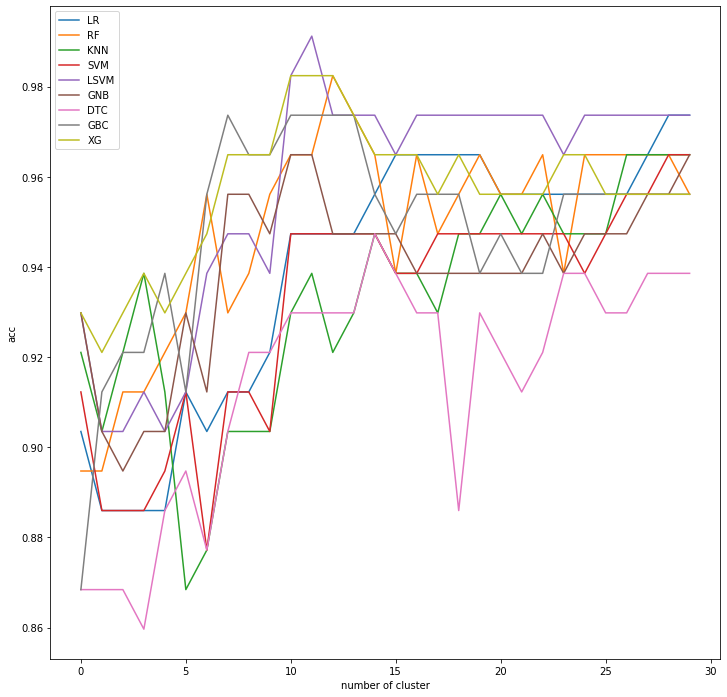

In [380]:
def plot_cluster_model_acc(model_list,model_acc_list,file_name ='cluster_output',fig_size = (12,12)):
    plt.figure(figsize=fig_size)
    plt.xlabel('number of cluster')
    plt.ylabel('acc')
    
    #idx = 0
    #print(model_acc_list)
    #model_name_list = []
    #for name,_ in model_list:
    #    model_name_list.append(name)
    
    
    #plt.plot(range(len(model_acc_list)), model_acc_list,label = model_name_list)
    
    idx = 0
    for name,_ in model_list:
        print(name)
        plt.plot(range(len(model_acc_list)), model_acc_list[:,[idx]],label = name)
        idx = idx+1
        
        
    plt.legend()
    plt.savefig(file_name+'.png')
    
plot_cluster_model_acc(model_list,final_cluster_result)